In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# import os
# for dirname, _, filenames in os.walk(root_path):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


**Importing the dataset for named entity recognition model**

<ipython-input-5-ace0adc9ad1e>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = dataset.groupby("sentence", group_keys=False).apply(agg_func)


Maximum sequence length: 5431


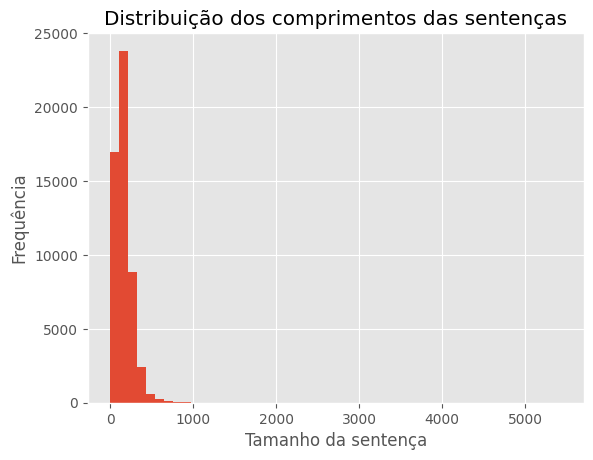

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Caminho para o seu dataset
csv_path = root_path + "IOB_relatos_consolidado_chatgpt_clear.csv"

# 1. Ler o arquivo CSV
wikiner_data = pd.read_csv(csv_path, encoding='latin1')

# 2. Preencher valores ausentes
wikiner_data = wikiner_data.ffill(axis=0)

# 3. Renomear colunas
wikiner_data.rename(columns={
    "row_id": "sentence",
    "Palavra": "word",
    "Tag IOB": "tag"
}, inplace=True)

# 4. Converter "sentence" para inteiro
wikiner_data["sentence"] = wikiner_data["sentence"].astype(int)

# 5. Manter apenas as colunas necessárias
wikiner_data = wikiner_data[["sentence", "word", "tag"]]

# Classe para agrupar as sentenças
class SentenceGetter(object):
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(), s["tag"].values.tolist())]
        self.grouped = dataset.groupby("sentence", group_keys=False).apply(agg_func)
        self.sentences = list(self.grouped)

    def get_next(self):
        try:
            s = self.grouped["sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

# Instanciar e usar o getter
getter = SentenceGetter(wikiner_data)
sentences = getter.sentences

# Analisar o comprimento das sentenças
maxlen = max([len(s) for s in sentences])
print('Maximum sequence length:', maxlen)

# Visualizar distribuição de tamanho das sentenças
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel("Tamanho da sentença")
plt.ylabel("Frequência")
plt.title("Distribuição dos comprimentos das sentenças")
plt.show()


> **Create list of list of tuples to differentiate each sentence from each other**

**Converting words to numbers and numbers to words**

In [ ]:
# 0 - Create list of list of tuples to differentiate each sentence from each other

words = list(set(wikiner_data["word"].values))
words.append("ENDPAD")
n_words = len(words); n_words
tags = list(set(wikiner_data["tag"].values))
n_tags = len(tags); n_tags




# 1. Mapear palavras e tags para índices
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

# 2. Preparar os dados de entrada (X)
from keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(
    maxlen=242,
    sequences=X,
    padding="post",
    value=len(words) - 1  # valor para PAD
)

# 3. Preparar os dados de saída (y)
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(
    maxlen=242,
    sequences=y,
    padding="post",
    value=tag2idx["O"]
)

# 4. One-hot encoding para as tags
from keras.utils import to_categorical

n_tags = len(tag2idx)
y_idx = y  # manter as tags como índices para a CRF
# Para modelos que não usam CRF (se quiser testar), use one-hot
y = [to_categorical(seq, num_classes=n_tags) for seq in y]


# 5. Dividir os dados em treino e teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 6. Importar camadas da rede neural
from keras.models import Model
from keras.layers import (
    LSTM, Embedding, Dense, TimeDistributed,
    Dropout, Bidirectional, Input
)


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-f6wdcgui
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-f6wdcgui
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Input
)

# Valores reais extraídos dos dados
n_words = len(words)
n_tags = len(tag2idx)

# [1] Definindo a entrada e o "backbone"
input_layer = Input(shape=(242,), name="input_ids")

x = Embedding(
    input_dim=n_words + 1,
    output_dim=20,
    input_length=242
    # mask_zero=True → REMOVIDO
)(input_layer)


x = Bidirectional(
    LSTM(units=50, return_sequences=True, recurrent_dropout=0.1)
)(x)

x = TimeDistributed(Dense(50, activation="relu"))(x)

# [2] Saída com softmax para classificação token a token
output = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

# [3] Construção e compilação do modelo
model = Model(inputs=input_layer, outputs=output)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, 242)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 242, 20)        │     4,899,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 242, 100)       │        28,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 242, 50)        │         5,050 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 242, 25)        │         1,275 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,933,885 (18.82 MB)

 Trainable params: 4,933,885 (18.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

model.fit(X_train, np.array(y_train), batch_size=32, epochs=1, validation_split=0.2)


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 899s 808ms/step - accuracy: 0.9494 - loss: 0.3881 - val_accuracy: 0.9707 - val_loss: 0.1040


In [ ]:
# i = 1
# p = model.predict(np.array([X_test[i]]))
# p = np.argmax(p, axis=-1)
# print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
# for w,pred in zip(X_test[i],p[0]):
#     print("{:15}: {}".format(words[w],tags[pred]))

In [ ]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

332/332 ━━━━━━━━━━━━━━━━━━━━ 46s 118ms/step


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=22fb308c29db23151892e21aaf61e358e75b471a30e7bd8b465727bad27c250d
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
!pip install seqeval
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install sklearn_crfsuite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=9e2319b5ada516f983660f0f757edd75f5e246b4d1330fe760552d8476f8187a
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-0wqxhjrv
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-0wqxhjrv
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras_contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101058 sha256=05108ec0a3760e7924cd9e2b40683f79b4004614348f9b5b92b94d4e734dcfb5
  Stored in directory: /tmp/pip-ephem-wheel-c

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Input
from sklearn_crfsuite.metrics import flat_classification_report
import unicodedata

# Configurações
MAXLEN = 512
root_path = './gdrive/My Drive/AKCIT - NLP (Desidentificação e identificação de dados sensíveis)/Testes'
csv_path = root_path + "/IOB_relatos_consolidado_chatgpt_clear.csv"

# 1. Ler o CSV
wikiner_data = pd.read_csv(csv_path, encoding='utf-8')
wikiner_data = wikiner_data.ffill(axis=0)

# 2. Renomear colunas
wikiner_data.rename(columns={
    "row_id": "sentence",
    "Palavra": "word",
    "Tag IOB": "tag"
}, inplace=True)

# 3. Normalizar texto
def normalize_word(w):
    return unicodedata.normalize("NFKD", w).encode("ASCII", "ignore").decode("utf-8").lower()

wikiner_data["word"] = wikiner_data["word"].apply(normalize_word)
wikiner_data["tag"] = wikiner_data["tag"].astype(str)
wikiner_data["sentence"] = wikiner_data["sentence"].astype(int)
wikiner_data = wikiner_data[["sentence", "word", "tag"]]

# 4. Agrupar sentenças
class SentenceGetter:
    def __init__(self, dataset):
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(), s["tag"].values.tolist())]
        self.grouped = dataset.groupby("sentence", group_keys=False).apply(agg_func)
        self.sentences = list(self.grouped)

getter = SentenceGetter(wikiner_data)
sentences = getter.sentences

# 5. Criar vocabulário
words = list(set(wikiner_data["word"].values))
words.append("ENDPAD")
n_words = len(words)

tags = list(set(wikiner_data["tag"].values))
n_tags = len(tags)

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: w for w, i in tag2idx.items()}

# 6. Preparar dados
X = [[word2idx.get(w[0], word2idx["ENDPAD"]) for w in s] for s in sentences]
X = pad_sequences(maxlen=MAXLEN, sequences=X, padding="post", value=word2idx["ENDPAD"])

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=MAXLEN, sequences=y, padding="post", value=tag2idx["O"])

y_idx = np.array(y)
y = [to_categorical(seq, num_classes=n_tags) for seq in y]

# 7. Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Modelo LSTM
input_layer = Input(shape=(MAXLEN,), name="input_ids")
x = Embedding(input_dim=n_words + 1, output_dim=20, input_length=MAXLEN)(input_layer)
x = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(x)
x = TimeDistributed(Dense(50, activation="relu"))(x)
output = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

# 9. Treinamento
model.fit(X_train, np.array(y_train), batch_size=32, epochs=5, validation_split=0.2)


<ipython-input-3-0ac5d5da9907>:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = dataset.groupby("sentence", group_keys=False).apply(agg_func)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 512, 20)        │     4,270,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 512, 100)       │        28,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 512, 50)        │         5,050 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 512, 25)        │         1,275 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,305,025 (16.42 MB)

 Trainable params: 4,305,025 (16.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 687s 615ms/step - accuracy: 0.9685 - loss: 0.2840 - val_accuracy: 0.9851 - val_loss: 0.0528
Epoch 2/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 637s 600ms/step - accuracy: 0.9859 - loss: 0.0483 - val_accuracy: 0.9873 - val_loss: 0.0398
Epoch 3/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 641s 604ms/step - accuracy: 0.9883 - loss: 0.0362 - val_accuracy: 0.9877 - val_loss: 0.0371
Epoch 4/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 632s 595ms/step - accuracy: 0.9897 - loss: 0.0308 - val_accuracy: 0.9879 - val_loss: 0.0361
Epoch 5/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 636s 599ms/step - accuracy: 0.9907 - loss: 0.0276 - val_accuracy: 0.9877 - val_loss: 0.0362


In [ ]:
# Caminho onde você quer salvar
save_dir = "./"
os.makedirs(save_dir, exist_ok=True)

# Salvar modelo
model.save(os.path.join(save_dir, "modelo_ner_lstm_softmax.h5"))

# Salvar vocabulários
with open(os.path.join(save_dir, "word2idx.json"), "w", encoding="utf-8") as f:
    json.dump(word2idx, f, ensure_ascii=False)

with open(os.path.join(save_dir, "idx2tag.json"), "w", encoding="utf-8") as f:
    json.dump(idx2tag, f, ensure_ascii=False)


NameError: name 'os' is not defined

In [ ]:
import os
import json
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 🔁 Converter predições (softmax -> índice -> label)
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

# 🔁 Remover B-/I- para avaliar apenas o tipo
def strip_bio_prefix(tags_nested):
    return [[tag.replace("B-", "").replace("I-", "") for tag in sentence] for sentence in tags_nested]

# 🔁 Obter predições
test_pred = model.predict(X_test, verbose=1)
pred_labels = pred2label(test_pred)
true_labels = pred2label(y_test)

# 🔁 Com prefixos
flat_true_bio = [tag for seq in true_labels for tag in seq if tag != 'O']
flat_pred_bio = [tag for seq in pred_labels for tag in seq if tag != 'O']
labels_bio = sorted(list(set(flat_true_bio + flat_pred_bio)))

print("=== RELATÓRIO COM PREFIXOS B-/I- ===")
report_bio = classification_report(flat_true_bio, flat_pred_bio, labels=labels_bio)
print(report_bio)

# 🔁 Sem prefixos
flat_true_plain = [tag for seq in strip_bio_prefix(true_labels) for tag in seq if tag != 'O']
flat_pred_plain = [tag for seq in strip_bio_prefix(pred_labels) for tag in seq if tag != 'O']
labels_plain = sorted(list(set(flat_true_plain + flat_pred_plain)))

print("\n=== RELATÓRIO SEM PREFIXOS B-/I- ===")
report_plain = classification_report(flat_true_plain, flat_pred_plain, labels=labels_plain)
print(report_plain)

# 🔁 Matriz de Confusão - COM prefixos
cm_bio = confusion_matrix(flat_true_bio, flat_pred_bio, labels=labels_bio)
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay(cm_bio, display_labels=labels_bio).plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão - LSTM (com B-/I-)")
plt.tight_layout()
plt.savefig("confusion_matrix_lstm_com_prefixos.png")
plt.show()

# 🔁 Matriz de Confusão - SEM prefixos
cm_plain = confusion_matrix(flat_true_plain, flat_pred_plain, labels=labels_plain)
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay(cm_plain, display_labels=labels_plain).plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão - LSTM (sem B-/I-)")
plt.tight_layout()
plt.savefig("confusion_matrix_lstm_sem_prefixos.png")
plt.show()

# === SALVAR TUDO NO GOOGLE DRIVE ===
GDRIVE_EVAL_DIR = os.path.join(root_path, "avaliacao_lstm")
os.makedirs(GDRIVE_EVAL_DIR, exist_ok=True)

def salvar_json(obj, nome_arquivo):
    with open(os.path.join(GDRIVE_EVAL_DIR, nome_arquivo), "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

# 📝 Salvar predições e rótulos
salvar_json(pred_labels, "pred_labels_bio.json")
salvar_json(true_labels, "true_labels_bio.json")
salvar_json(strip_bio_prefix(pred_labels), "pred_labels_plain.json")
salvar_json(strip_bio_prefix(true_labels), "true_labels_plain.json")

# 🧠 Salvar mapeamentos
salvar_json(word2idx, "word2idx.json")
salvar_json(tag2idx, "tag2idx.json")
salvar_json(idx2tag, "idx2tag.json")

# 📄 Salvar relatórios como texto
with open(os.path.join(GDRIVE_EVAL_DIR, "classification_report_bio.txt"), "w", encoding="utf-8") as f:
    f.write(report_bio)

with open(os.path.join(GDRIVE_EVAL_DIR, "classification_report_plain.txt"), "w", encoding="utf-8") as f:
    f.write(report_plain)

print(f"\n✅ Resultados salvos em: {GDRIVE_EVAL_DIR}")


332/332 ━━━━━━━━━━━━━━━━━━━━ 45s 103ms/step
=== RELATÓRIO COM PREFIXOS B-/I- ===


ValueError: Found input variables with inconsistent numbers of samples: [136615, 124917]

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Converter predições (softmax -> índice -> label)
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

# Remover B-/I- para avaliar apenas o tipo
def strip_bio_prefix(tags_nested):
    return [[tag.replace("B-", "").replace("I-", "") for tag in sentence] for sentence in tags_nested]



# Flatten geral para report
flat_true_bio_all = [tag for seq in true_labels for tag in seq]
flat_pred_bio_all = [tag for seq in pred_labels for tag in seq]
flat_true_plain_all = [tag for seq in strip_bio_prefix(true_labels) for tag in seq]
flat_pred_plain_all = [tag for seq in strip_bio_prefix(pred_labels) for tag in seq]

# Flatten sem "O" para matriz
flat_true_bio = []
flat_pred_bio = []
for t_seq, p_seq in zip(true_labels, pred_labels):
    for t, p in zip(t_seq, p_seq):
        if t != "O":
            flat_true_bio.append(t)
            flat_pred_bio.append(p)

flat_true_plain = []
flat_pred_plain = []
for t_seq, p_seq in zip(strip_bio_prefix(true_labels), strip_bio_prefix(pred_labels)):
    for t, p in zip(t_seq, p_seq):
        if t != "O":
            flat_true_plain.append(t)
            flat_pred_plain.append(p)

# Labels
labels_bio = sorted(list(set(flat_true_bio + flat_pred_bio)))
labels_plain = sorted(list(set(flat_true_plain + flat_pred_plain)))
labels_bio_all = sorted(list(set(flat_true_bio_all + flat_pred_bio_all)))
labels_plain_all = sorted(list(set(flat_true_plain_all + flat_pred_plain_all)))

# Relatórios
print("=== RELATÓRIO COM PREFIXOS B-/I- ===")
report_bio = classification_report(flat_true_bio_all, flat_pred_bio_all, labels=labels_bio_all)
print(report_bio)

print("\n=== RELATÓRIO SEM PREFIXOS B-/I- ===")
report_plain = classification_report(flat_true_plain_all, flat_pred_plain_all, labels=labels_plain_all)
print(report_plain)

# Matriz de Confusão - COM prefixos
cm_bio = confusion_matrix(flat_true_bio, flat_pred_bio, labels=labels_bio)
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay(cm_bio, display_labels=labels_bio).plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão - LSTM (com B-/I-)")
plt.tight_layout()
plt.savefig("confusion_matrix_lstm_com_prefixos.eps", format="eps")
plt.show()

# Matriz de Confusão - SEM prefixos
cm_plain = confusion_matrix(flat_true_plain, flat_pred_plain, labels=labels_plain)
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay(cm_plain, display_labels=labels_plain).plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão - LSTM (sem B-/I-)")
plt.tight_layout()
plt.savefig("confusion_matrix_lstm_sem_prefixos.eps", format="eps")
plt.show()

# === SALVAR TUDO NO GOOGLE DRIVE ===
GDRIVE_EVAL_DIR = os.path.join(root_path, "avaliacao_lstm")
os.makedirs(GDRIVE_EVAL_DIR, exist_ok=True)

def salvar_json(obj, nome_arquivo):
    with open(os.path.join(GDRIVE_EVAL_DIR, nome_arquivo), "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

# Salvar predições e rótulos
salvar_json(pred_labels, "pred_labels_bio.json")
salvar_json(true_labels, "true_labels_bio.json")
salvar_json(strip_bio_prefix(pred_labels), "pred_labels_plain.json")
salvar_json(strip_bio_prefix(true_labels), "true_labels_plain.json")

# Salvar mapeamentos
salvar_json(word2idx, "word2idx.json")
salvar_json(tag2idx, "tag2idx.json")
salvar_json(idx2tag, "idx2tag.json")

# Salvar relatórios
with open(os.path.join(GDRIVE_EVAL_DIR, "classification_report_bio.txt"), "w", encoding="utf-8") as f:
    f.write(report_bio)

with open(os.path.join(GDRIVE_EVAL_DIR, "classification_report_plain.txt"), "w", encoding="utf-8") as f:
    f.write(report_plain)

print(f"\n✅ Resultados salvos em: {GDRIVE_EVAL_DIR}")

NameError: name 'true_labels' is not defined

=== RELATÓRIO COM PREFIXOS B-/I- ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     B-BANCO       0.46      0.16      0.24      1806
       B-CNH       0.75      0.71      0.73       353
      B-CNPJ       0.81      0.63      0.71       278
       B-CPF       0.72      0.74      0.73      2013
  B-DEPOENTE       0.00      0.00      0.00       144
     B-EMAIL       0.84      0.85      0.84      1784
   B-EMPRESA       0.66      0.50      0.57      3097
  B-ENDEREÇO       0.59      0.44      0.51      7225
    B-PESSOA       0.75      0.73      0.74     28656
        B-RG       0.73      0.69      0.71       674
  B-TELEFONE       0.58      0.52      0.55      4652
   B-VEÍCULO       0.63      0.58      0.61      9526
     I-BANCO       0.47      0.23      0.31      1345
       I-CNH       0.00      0.00      0.00        90
      I-CNPJ       0.74      0.75      0.74       181
       I-CPF       0.70      0.79      0.74      1079
  I-DEPOENTE       0.00      0.00      0.00       116
     I-EMAIL       0.63    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       BANCO       0.67      0.27      0.38      3151
         CNH       0.76      0.57      0.65       443
        CNPJ       0.88      0.78      0.83       459
         CPF       0.83      0.89      0.86      3092
    DEPOENTE       0.00      0.00      0.00       260
       EMAIL       0.79      0.82      0.80      2845
     EMPRESA       0.70      0.58      0.63      7348
    ENDEREÇO       0.65      0.52      0.58     20672
           O       0.99      1.00      0.99   5301337
      PESSOA       0.86      0.85      0.85     72131
          RG       0.80      0.74      0.77      1104
    TELEFONE       0.82      0.69      0.75      7437
     VEÍCULO       0.74      0.64      0.68     17673

    accuracy                           0.99   5437952
   macro avg       0.73      0.64      0.68   5437952
weighted avg       0.99      0.99      0.99   5437952

=== RELATÓRIO COM PREFIXOS B-/I- (sem 'O') ===
              precision    recal

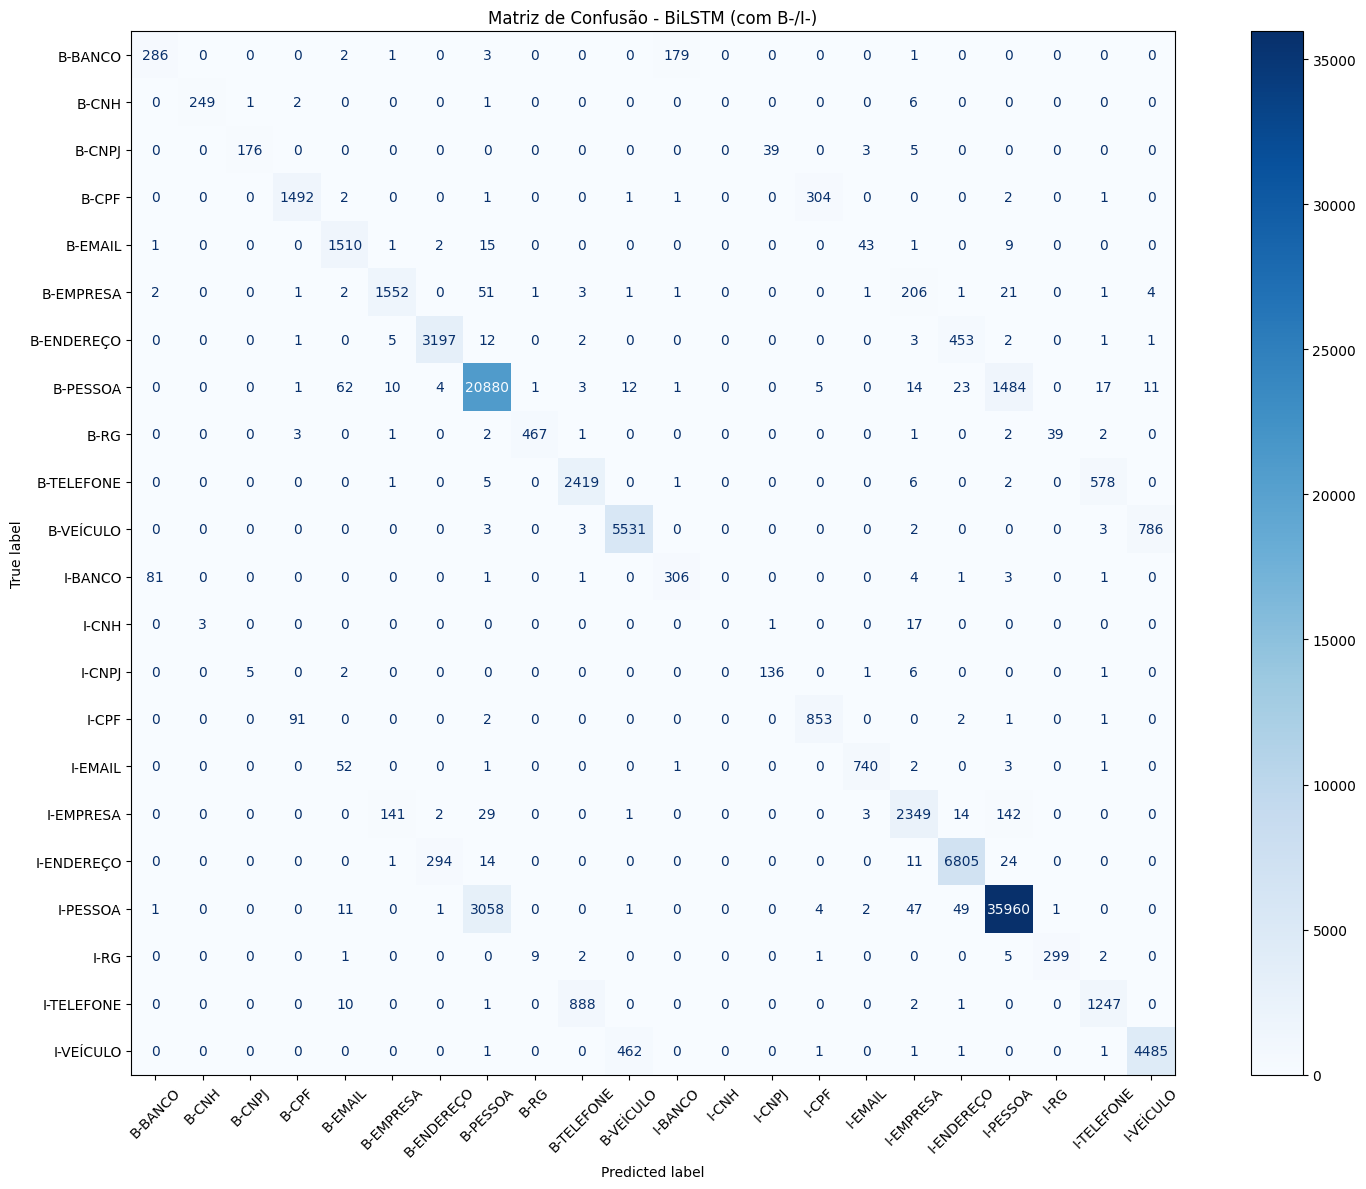

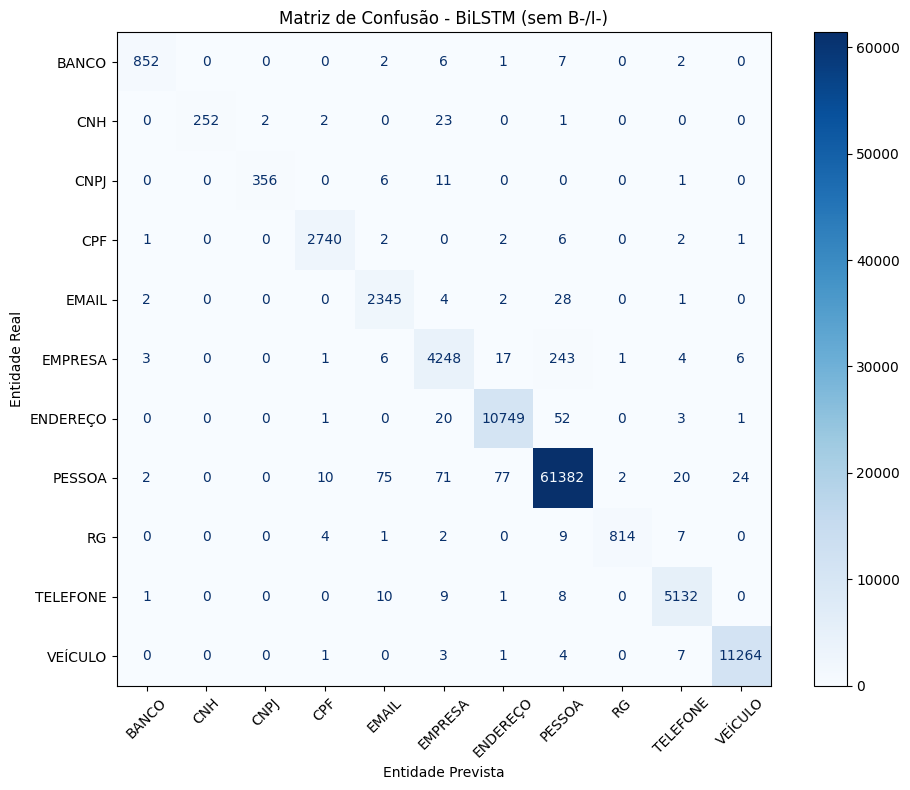

In [3]:
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Caminho para os resultados salvos no Google Drive
GDRIVE_EVAL_DIR = "/content/gdrive/MyDrive/AKCIT - NLP (Desidentificação e identificação de dados sensíveis)/modelos-selecionados/avaliacao_lstm/"


# Função para carregar JSON
def carregar_json(nome_arquivo):
    caminho = os.path.join(GDRIVE_EVAL_DIR, nome_arquivo)
    with open(caminho, "r", encoding="utf-8") as f:
        return json.load(f)

# Carregar arquivos
true_labels_bio = carregar_json("true_labels_bio.json")
pred_labels_bio = carregar_json("pred_labels_bio.json")
true_labels_plain = carregar_json("true_labels_plain.json")
pred_labels_plain = carregar_json("pred_labels_plain.json")

# Flatten geral (para report)
flat_true_bio_all = [tag for seq in true_labels_bio for tag in seq]
flat_pred_bio_all = [tag for seq in pred_labels_bio for tag in seq]
flat_true_plain_all = [tag for seq in true_labels_plain for tag in seq]
flat_pred_plain_all = [tag for seq in pred_labels_plain for tag in seq]

# Flatten sem 'O' (para matriz)
flat_true_bio = []
flat_pred_bio = []
for t_seq, p_seq in zip(true_labels_bio, pred_labels_bio):
    for t, p in zip(t_seq, p_seq):
        if t != "O":
            flat_true_bio.append(t)
            flat_pred_bio.append(p)

flat_true_plain = []
flat_pred_plain = []
for t_seq, p_seq in zip(true_labels_plain, pred_labels_plain):
    for t, p in zip(t_seq, p_seq):
        if t != "O":
            flat_true_plain.append(t)
            flat_pred_plain.append(p)

# Labels (matriz sem "O", relatórios com "O")
labels_bio = sorted(list(set(flat_true_bio + flat_pred_bio) - {"O", "DEPOENTE", "B-DEPOENTE", "I-DEPOENTE"}))
labels_plain = sorted(list(set(flat_true_plain + flat_pred_plain) - {"O", "DEPOENTE","B-DEPOENTE", "I-DEPOENTE"}))
labels_bio_all = sorted(list(set(flat_true_bio_all + flat_pred_bio_all)))
labels_plain_all = sorted(list(set(flat_true_plain_all + flat_pred_plain_all)))

all_non_o_bio   = sorted(list(set(flat_true_bio   + flat_pred_bio)))
all_non_o_plain = sorted(list(set(flat_true_plain + flat_pred_plain)))

# Avaliação
print("=== RELATÓRIO COM PREFIXOS B-/I- ===")
report_bio = classification_report(flat_true_bio_all, flat_pred_bio_all, labels=labels_bio_all)
print(report_bio)

print("\n=== RELATÓRIO SEM PREFIXOS B-/I- ===")
report_plain = classification_report(flat_true_plain_all, flat_pred_plain_all, labels=labels_plain_all)
print(report_plain)

print("=== RELATÓRIO COM PREFIXOS B-/I- (sem 'O') ===")
report_bio = classification_report(flat_true_bio, flat_pred_bio,
                                   labels=all_non_o_bio, zero_division=0)
print(report_bio)

print("\n=== RELATÓRIO SEM PREFIXOS B-/I- (sem 'O') ===")
report_plain = classification_report(flat_true_plain, flat_pred_plain,
                                     labels=all_non_o_plain, zero_division=0)
print(report_plain)


# Matriz de confusão - com prefixos
cm_bio = confusion_matrix(flat_true_bio, flat_pred_bio, labels=labels_bio)
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_xlabel("Entidade Prevista")
ax.set_ylabel("Entidade Real")
ConfusionMatrixDisplay(cm_bio, display_labels=labels_bio).plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão - BiLSTM (com B-/I-)")
plt.tight_layout()
plt.savefig("confusion_matrix_lstm_bio_recuperado.eps", format="eps")
plt.show()

# Matriz de confusão - sem prefixos
cm_plain = confusion_matrix(flat_true_plain, flat_pred_plain, labels=labels_plain)
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay(cm_plain, display_labels=labels_plain).plot(cmap="Blues", ax=ax, xticks_rotation=45)
# Alterando os nomes dos eixos
ax.set_xlabel("Entidade Prevista")
ax.set_ylabel("Entidade Real")

plt.title("Matriz de Confusão - BiLSTM (sem B-/I-)")
plt.tight_layout()
plt.savefig("confusion_matrix_lstm_plain_recuperado.eps", format="eps")
plt.show()


In [ ]:
# Salvar o modelo treinado
root_path = './gdrive/My Drive/AKCIT - NLP (Desidentificação e identificação de dados sensíveis)/Testes/'
model.save(root_path + "modelo_ner_lstm_softmax.h5")

# Salvar dados de teste
np.save(root_path + "X_test.npy", X_test)
np.save(root_path + "y_test.npy", y_test)

# Salvar dicionários de vocabulário
import json
with open(root_path + "word2idx.json", "w", encoding="utf-8") as f:
    json.dump(word2idx, f, ensure_ascii=False)

with open(root_path + "tag2idx.json", "w", encoding="utf-8") as f:
    json.dump(tag2idx, f, ensure_ascii=False)

print("✅ Modelo e dados salvos no Google Drive com sucesso!")


✅ Modelo e dados salvos no Google Drive com sucesso!


In [ ]:

# 12. Converter predições
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

test_pred = model.predict(X_test, verbose=1)
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

# 13. Avaliar
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)


332/332 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step
[[[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0.

In [ ]:
from keras.models import load_model
import numpy as np
import json
from sklearn_crfsuite.metrics import flat_classification_report

# Caminho base
root_path = './gdrive/My Drive/AKCIT - NLP (Desidentificação e identificação de dados sensíveis)/Testes/'

# Carregar modelo treinado
model = load_model(root_path + "modelo_ner_lstm_softmax.h5")

# Carregar dados de teste
X_test = np.load(root_path + "X_test.npy", allow_pickle=True)
y_test = np.load(root_path + "y_test.npy", allow_pickle=True)

# Carregar dicionários
with open(root_path + "word2idx.json", encoding="utf-8") as f:
    word2idx = json.load(f)

with open(root_path + "tag2idx.json", encoding="utf-8") as f:
    tag2idx = json.load(f)

# Reconstruir idx2tag
idx2tag = {int(v): k for k, v in tag2idx.items()}
n_tags = len(tag2idx)

# Funções auxiliares
def strip_prefix(tag):
    return tag.replace("B-", "").replace("I-", "")

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out

def true2label(y_true):
    out = []
    for true_seq in y_true:
        out_i = []
        for vec in true_seq:
            idx = np.argmax(vec)
            out_i.append(idx2tag[idx])
        out.append(out_i)
    return out

# Prever

test_pred = model.predict(X_test, verbose=1)



332/332 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step
              precision    recall  f1-score   support

     B-BANCO       0.35      0.30      0.32      1774
       B-CNH       0.75      0.72      0.74       322
      B-CNPJ       0.78      0.74      0.76       280
       B-CPF       0.69      0.62      0.65      1639
  B-DEPOENTE       0.13      0.02      0.04        95
     B-EMAIL       0.86      0.84      0.85      1733
   B-EMPRESA       0.60      0.48      0.53      2726
  B-ENDEREÇO       0.54      0.48      0.51      6538
    B-PESSOA       0.75      0.70      0.72     25150
        B-RG       0.71      0.69      0.70       574
  B-TELEFONE       0.58      0.50      0.54      4288
   B-VEÍCULO       0.62      0.61      0.61      8757
     I-BANCO       0.35      0.36      0.35      1321
       I-CNH       0.71      0.44      0.55       106
      I-CNPJ       0.72      0.88      0.79       183
       I-CPF       0.63      0.81      0.71       819
  I-DEPOENTE       0.50      0.01     

In [ ]:
pred_labels = pred2label(test_pred)
test_labels = true2label(y_test)


def strip_bio_prefix(tags_nested):
    return [[tag.replace("B-", "").replace("I-", "") for tag in sentence] for sentence in tags_nested]


# Avaliação
report = flat_classification_report(y_pred=strip_bio_prefix(pred_labels), y_true=strip_bio_prefix(test_labels))
print(report)

              precision    recall  f1-score   support

       BANCO       0.51      0.47      0.49      3095
         CNH       0.80      0.70      0.74       428
        CNPJ       0.85      0.90      0.87       463
         CPF       0.80      0.82      0.81      2458
    DEPOENTE       0.29      0.03      0.05       178
       EMAIL       0.81      0.78      0.80      2850
     EMPRESA       0.66      0.56      0.61      6517
    ENDEREÇO       0.59      0.55      0.57     18690
           O       0.99      0.99      0.99   2449042
      PESSOA       0.86      0.85      0.85     62756
          RG       0.76      0.74      0.75       919
    TELEFONE       0.79      0.69      0.74      6642
     VEÍCULO       0.70      0.69      0.70     16244

    accuracy                           0.98   2570282
   macro avg       0.72      0.68      0.69   2570282
weighted avg       0.98      0.98      0.98   2570282



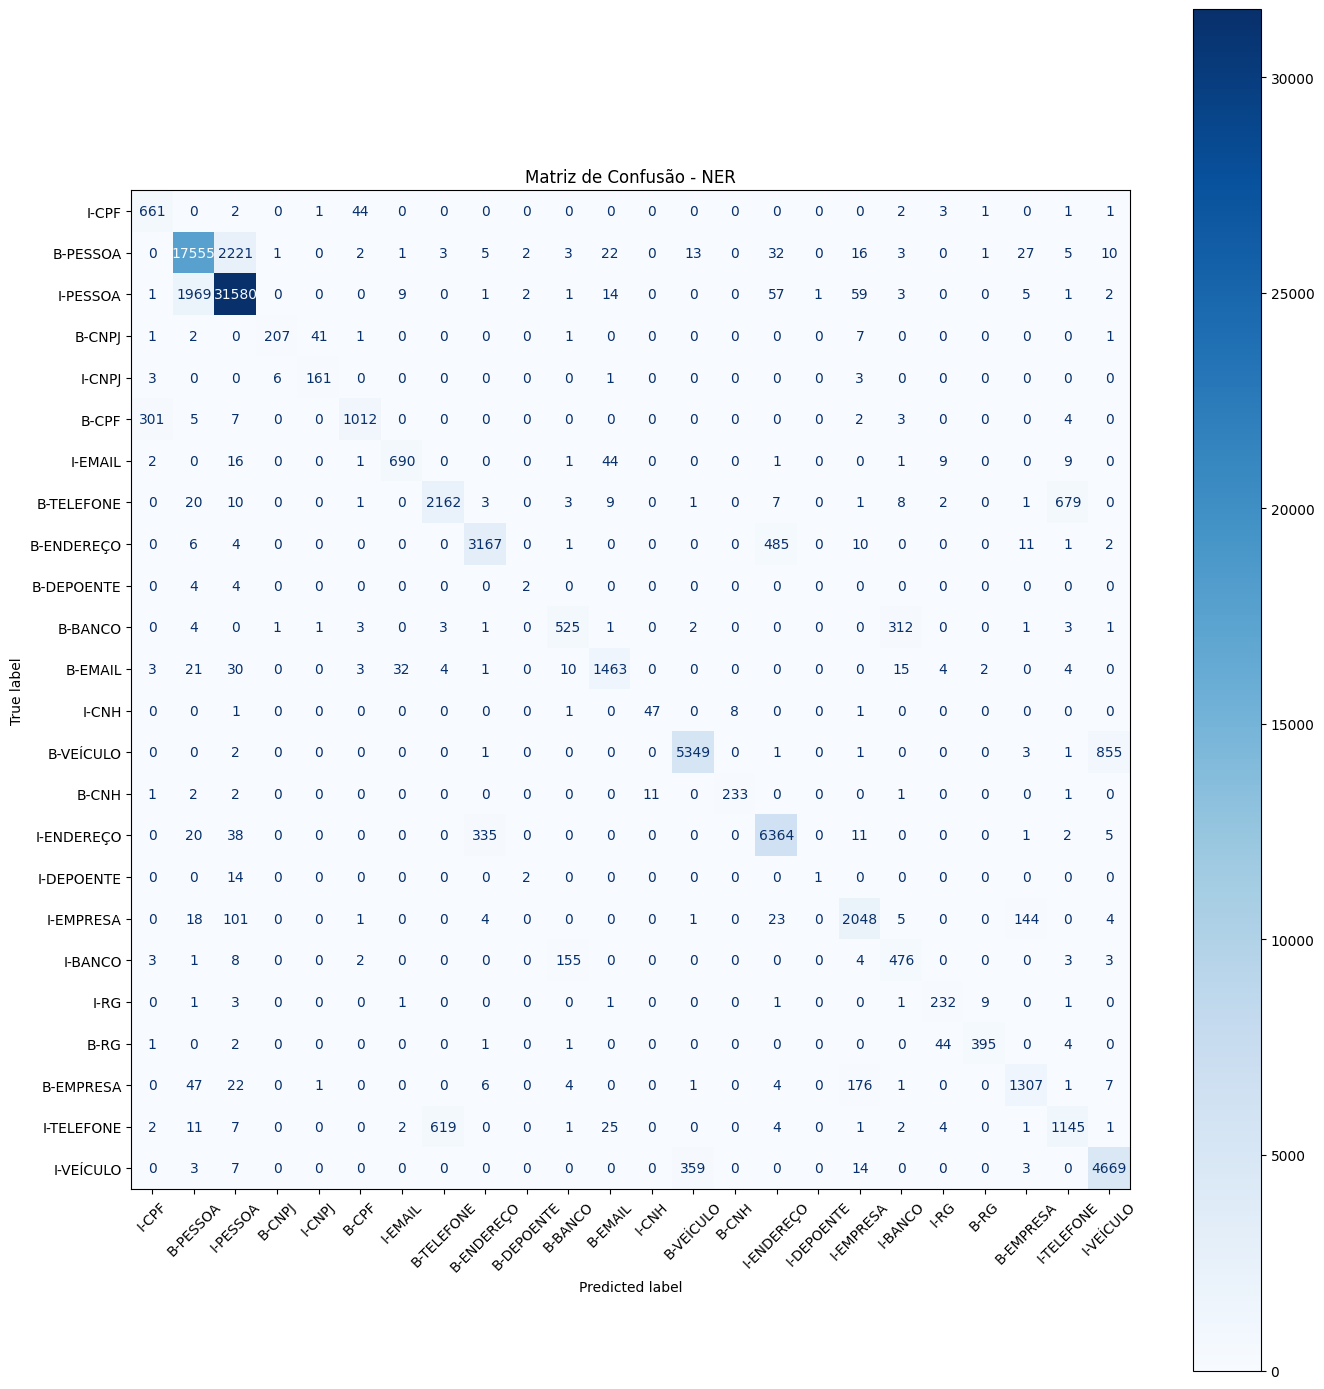

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Flatten dos rótulos
y_true_flat = [tag for sentence in test_labels for tag in sentence]
y_pred_flat = [tag for sentence in pred_labels for tag in sentence]

# Remover classe 'O'
filtered = [(t, p) for t, p in zip(y_true_flat, y_pred_flat) if t != 'O']
y_true_filtered, y_pred_filtered = zip(*filtered)

# Rótulos sem 'O'
labels = [label for label in tag2idx.keys() if label != 'O']

# Matriz de confusão
cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=labels)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão - NER")
plt.tight_layout()
plt.show()
